In [1]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,BatchNormalization,Activation, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import cv2
import time
import datetime
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model

In [2]:
img_size =  128
num_channels = 3
batch_size = 32

In [3]:
def video_to_frames(video):
    cap = cv2.VideoCapture(video)  # Open the video file for reading frames
    
    frames_list = []  # List to store the processed image frames
    while cap.isOpened():  # Loop until the video has been completely processed
        ID = cap.get(1)  # Get the current frame ID (1 corresponds to the frame number)
        success, image = cap.read()  # Read the next frame from the video

        if success:  # If the frame was read successfully
            # Skip frames to avoid duplications; process every 7th frame
            if (ID % 7 == 0):  
                # Define image augmentations
                flip = iaa.Fliplr(1.0)  # Always flip the image horizontally (left to right)
                zoom = iaa.Affine(scale=1.3)  # Zoom the image by 30%
                random_brightness = iaa.Multiply((1, 1.3))  # Adjust brightness randomly (between 100% and 130%)
                rotate = iaa.Affine(rotate=(-25, 25))  # Rotate the image randomly between -25 and 25 degrees

                # Apply augmentations in sequence
                aug = flip(image=image)  # Apply horizontal flip
                aug = random_brightness(image= aug)  # Adjust brightness
                aug = zoom(image= aug)  # Apply zoom
                aug = rotate(image= aug)  # Apply rotation
                
                # Convert the augmented image from BGR (OpenCV fimg_siz feormat) to RGB (common format)
                to_rgb = cv2.cvtColor(aug, cv2.COLOR_BGR2RGB)
                # Resize the image to the specified dimensions
                resized = cv2.resize(to_rgb, (img_size, img_size))
                frames_list.append(resized)  # Add the resized image to the list of frames
               
        else:
            break  
    
    cap.release()  # Release the video capture object
    
    return frames_list  # Return the list of processed image frames

In [4]:
VideoData = 'Test Dataset'  # 'Train' folder contains  each class ("NonViolence" and "Violence")


X  = [] # List to store frames (image data) extracted from videos
y  = [] # List to store labels corresponding to each frame


classes = ["NonViolence", "Violence"]   # Classes: NonViolence = 0, Violence = 1

# Loop through each class folder in the 'Train' directory
for category in os.listdir(VideoData): 
    path = os.path.join(VideoData, category)  
    class_num = classes.index(category)       # Get the numeric label for the current category (0 or 1)

    # Loop through each video in the current category folder
    for i, video in enumerate(os.listdir(path)): 
        frames = video_to_frames(path + '/' + video)  # Extract frames from the video using the video_to_frames function
        
        # Loop through each frame extracted from the video
        for j, frame in enumerate(frames): 
            X.append(frame)                    
            y.append(class_num)                


In [5]:
# Convert the lists of frames and labels into NumPy arrays
X = np.array(X)
y = np.array(y)                                       

print(len(X))

15598


In [6]:
# First split - Train (70%) vs Temp (30%)
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=73)

for train_index, temp_index in stratified.split(X, y):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Second split - Temp (15%) into Validation (50% of Temp) and Test (50% of Temp)
stratified1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=73)

for val_index, test_index in stratified1.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]




In [7]:
# Normalize the pixel values
X_train_norm = X_train/ 255
X_test_norm = X_test / 255
X_val_norm = X_val/ 255

In [8]:
print("Training set shape:", X_train_norm.shape, y_train.shape)
print("Validation set shape:", X_val_norm.shape, y_val.shape)
print("Test set shape:", X_test_norm.shape, y_test.shape)


Training set shape: (10918, 128, 128, 3) (10918,)
Validation set shape: (2340, 128, 128, 3) (2340,)
Test set shape: (2340, 128, 128, 3) (2340,)


In [9]:
# L2 regularization with a strength of 0.0001 to prevent overfitting
kernel_regularizer = regularizers.l2(0.0001)  

vgg = VGG19(input_shape=(img_size,img_size,num_channels), weights='imagenet', include_top=False)
#freezing pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
# Add the custom layers on top of VGG19
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu",kernel_regularizer=kernel_regularizer)(x)  # Add dense layer with 256 units and ReLU activation

# Final sigmoid layer for binary classification
prediction = Dense(1, activation='sigmoid',kernel_regularizer=kernel_regularizer)(x)

# Combine the VGG19 base and custom layers
model = Model(inputs=vgg.input, outputs=prediction)
# Print a message indicating that the model is being compiled
print("Compiling model...")  

# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy as the evaluation metric
model.compile(loss="binary_crossentropy", 
              optimizer='adam', 
              metrics=["accuracy"])  

# Print a summary of the model architecture, including layer types and output shapes
model.summary()  

Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
# Define parameters for learning rate scheduling and early stopping
epochs = 100
patience = 5
start_lr = 1e-5
max_lr = 2e-4
min_lr = 1e-6

rampup_epochs = 8
sustain_epochs = 0
exp_decay = 0.9

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.999:
            print("\nLimits Reached, cancelling training!")
            self.model.stop_training = True


end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)


lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience, min_lr=1e-7)

os.system('rm -rf ./logs/')


log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'VGG19ModelWeights.weights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]


In [11]:
# Training the model head 
print('Training head...')

# Start the timer before training
start_time = time.time()

history = model.fit(
    X_train_norm,                   # Training data normalized for input to the model.
    y_train,                        # Corresponding labels for the training data.
    epochs=epochs,                  # Number of epochs to train the model.
    callbacks=callbacks,            # List of callbacks to apply during training (like early stopping, learning rate adjustments).
    validation_data=(X_val_norm, y_val),  # Validation data and labels for evaluating model performance during training.
    batch_size=batch_size           # Number of samples per gradient update.
)
# End the timer after training
end_time = time.time()

# Notify the user that the best weights are being restored after training is complete.
print('\nRestoring best weights for VGG19')

# Calculate the total training time
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

# Load the best model weights that were saved during training based on the validation loss.
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5780 - loss: 0.7088
Epoch 1: val_loss improved from inf to 0.66541, saving model to VGG19ModelWeights.weights.h5
342/342 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.5782 - loss: 0.7088 - val_accuracy: 0.7184 - val_loss: 0.6654 - learning_rate: 1.0000e-05
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.7600 - loss: 0.6246
Epoch 2: val_loss improved from 0.66541 to 0.55132, saving model to VGG19ModelWeights.weights.h5
342/342 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.7600 - loss: 0.6245 - val_accuracy: 0.7744 - val_loss: 0.5513 - learning_rate: 3.3750e-05
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.7925 - loss: 0.5110
Epoch 3: val_loss improved from 0.55132 to 0.47570, saving model to VGG19ModelWeights.weights.h5
342/342 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.7926 - loss: 0.5109 - val_accuracy: 0.7936 - val_loss: 0.4757 - learning_rate: 5.750

In [24]:
#Best Validation Accuracy
best_val_acc = max(history.history['val_accuracy'])
print(f"Best validation Accuracy: {best_val_acc}")

Best validation Accuracy: 0.9085469841957092


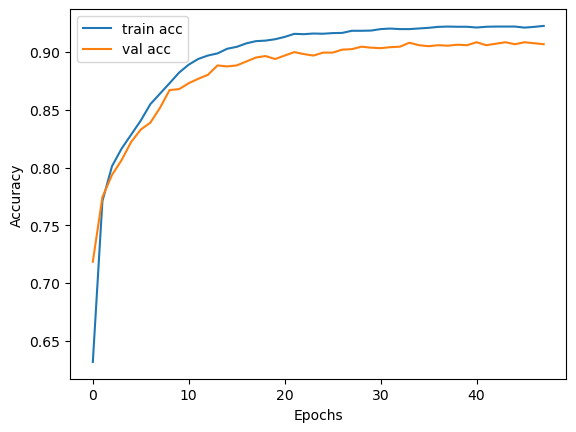

In [18]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

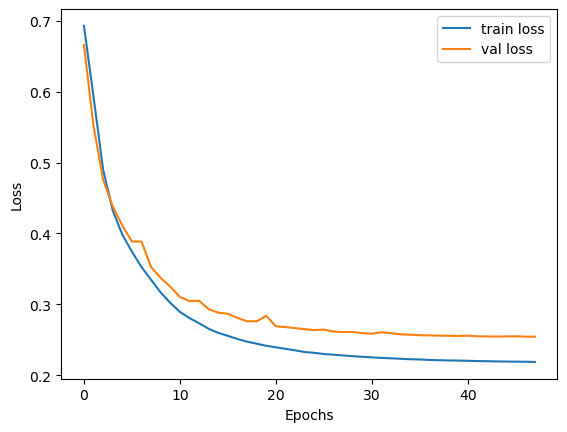

In [19]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test)
preds = predictions > 0.5

Evaluating network...
74/74 ━━━━━━━━━━━━━━━━━━━━ 68s 922ms/step


C:\Users\iamid\AppData\Local\Temp\ipykernel_13628\640220170.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="muted")


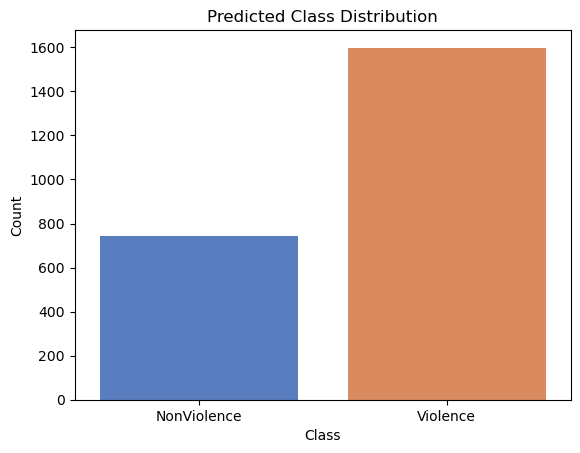

In [21]:
from collections import Counter
# Get predicted class distribution
predicted_classes = preds.astype(int).flatten()
class_counts = Counter(predicted_classes)

# Plot the class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="muted")
plt.xticks([0, 1], ['NonViolence', 'Violence'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Predicted Class Distribution')
plt.show()

> Correct Predictions: 1726
> Wrong Predictions: 614


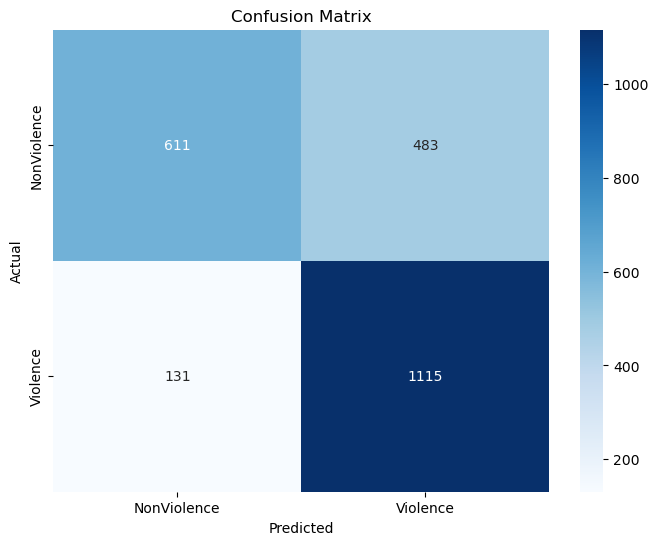

              precision    recall  f1-score   support

 NonViolence       0.82      0.56      0.67      1094
    Violence       0.70      0.89      0.78      1246

    accuracy                           0.74      2340
   macro avg       0.76      0.73      0.72      2340
weighted avg       0.76      0.74      0.73      2340



In [22]:
# Compute the confusion matrix
corr_pred = confusion_matrix(y_test, preds)

n_correct = int(corr_pred[0][0] + corr_pred[1][1])  # Count of correct predictions
print('> Correct Predictions:', n_correct)

n_wrongs = int(corr_pred[0][1] + corr_pred[1][0])  # Count of wrong predictions
print('> Wrong Predictions:', n_wrongs)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["NonViolence", "Violence"], 
            yticklabels=["NonViolence", "Violence"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()  # Ensure to call plt.show() to display the plot

# Print the classification report
print(metrics.classification_report(y_test, preds, 
                                     target_names=["NonViolence", "Violence"]))

In [23]:
args_model = "Violence Detection VGG19.h5"
model.save(args_model)

In [2]:
model = load_model("Violence Detection VGG19.h5")

In [3]:
# Function to preprocess each frame
def preprocess_frame(frame, img_size=128):
    # Convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Resize frame to match model's input size
    frame = cv2.resize(frame, (img_size, img_size))
    # Normalize pixel values
    frame = frame / 255.0
    # Expand dimensions to match model's input shape (1, 128, 128, 3)
    frame = np.expand_dims(frame, axis=0)
    return frame

In [7]:
# Function to predict and display frames with labels in real-time
def display_predictions_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(3, 500)  # Set width
    cap.set(4, 450)   # Set height
    violent_frames = []  # List to store frames with violence detected
    
    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
        
    
    frame_count = 0  # Counter to track the frames

    while cap.isOpened():
        success, frame = cap.read()
        
        if success:
            # Only process every 7th frame
            if frame_count % 7 == 0:
                # Preprocess the frame (resize, normalise, etc.)
                processed_frame = preprocess_frame(frame)

                # Predict using the model
                prediction = model.predict(processed_frame)

                # Determine label and corresponding color based on prediction
                if prediction >= 0.8:
                    label = "Violence"
                    color = (0, 0, 255)  # Red in BGR
                    violent_frames.append(frame)
                    
                else:
                    label = "NonViolence"
                    color = (0, 255, 0)  # Green in BGR
                print(f"- Prediction: {label}")

                # Overlay the label on the frame
                label_text = f"Prediction: {label}"
                cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

                # Display the frame with the label
                cv2.imshow("Video Prediction", frame)

            frame_count += 1  # Increment the frame counter

            # Press 'q' to quit early
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break
        else:
            print("End of video or read failure.")
            break  # Stop if the video has ended

    cap.release()
    cv2.destroyAllWindows()
    return violent_frames

In [8]:
def display_stored_violence_frames(violence_frames, rows=6, cols=6):
    num_frames = len(violence_frames)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()  # Flatten the 2D axes array for easier iteration

    for i, ax in enumerate(axes):
        if i < num_frames:
            # Convert BGR to RGB for displaying in Matplotlib
            frame_rgb = cv2.cvtColor(violence_frames[i], cv2.COLOR_BGR2RGB)
            ax.imshow(frame_rgb)
            ax.set_title(f"Frame {i+1}")
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide any unused subplot spaces

    plt.tight_layout()
    plt.show()

In [9]:
# Test on an unseen video
video_path =  "9.mp4"  # Replace with the video file path
violent_frames = display_predictions_in_video(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
- Prediction: NonViolence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
- Prediction: Violence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
- Prediction: Violence
1/1

Number of violence-detected frames: 25


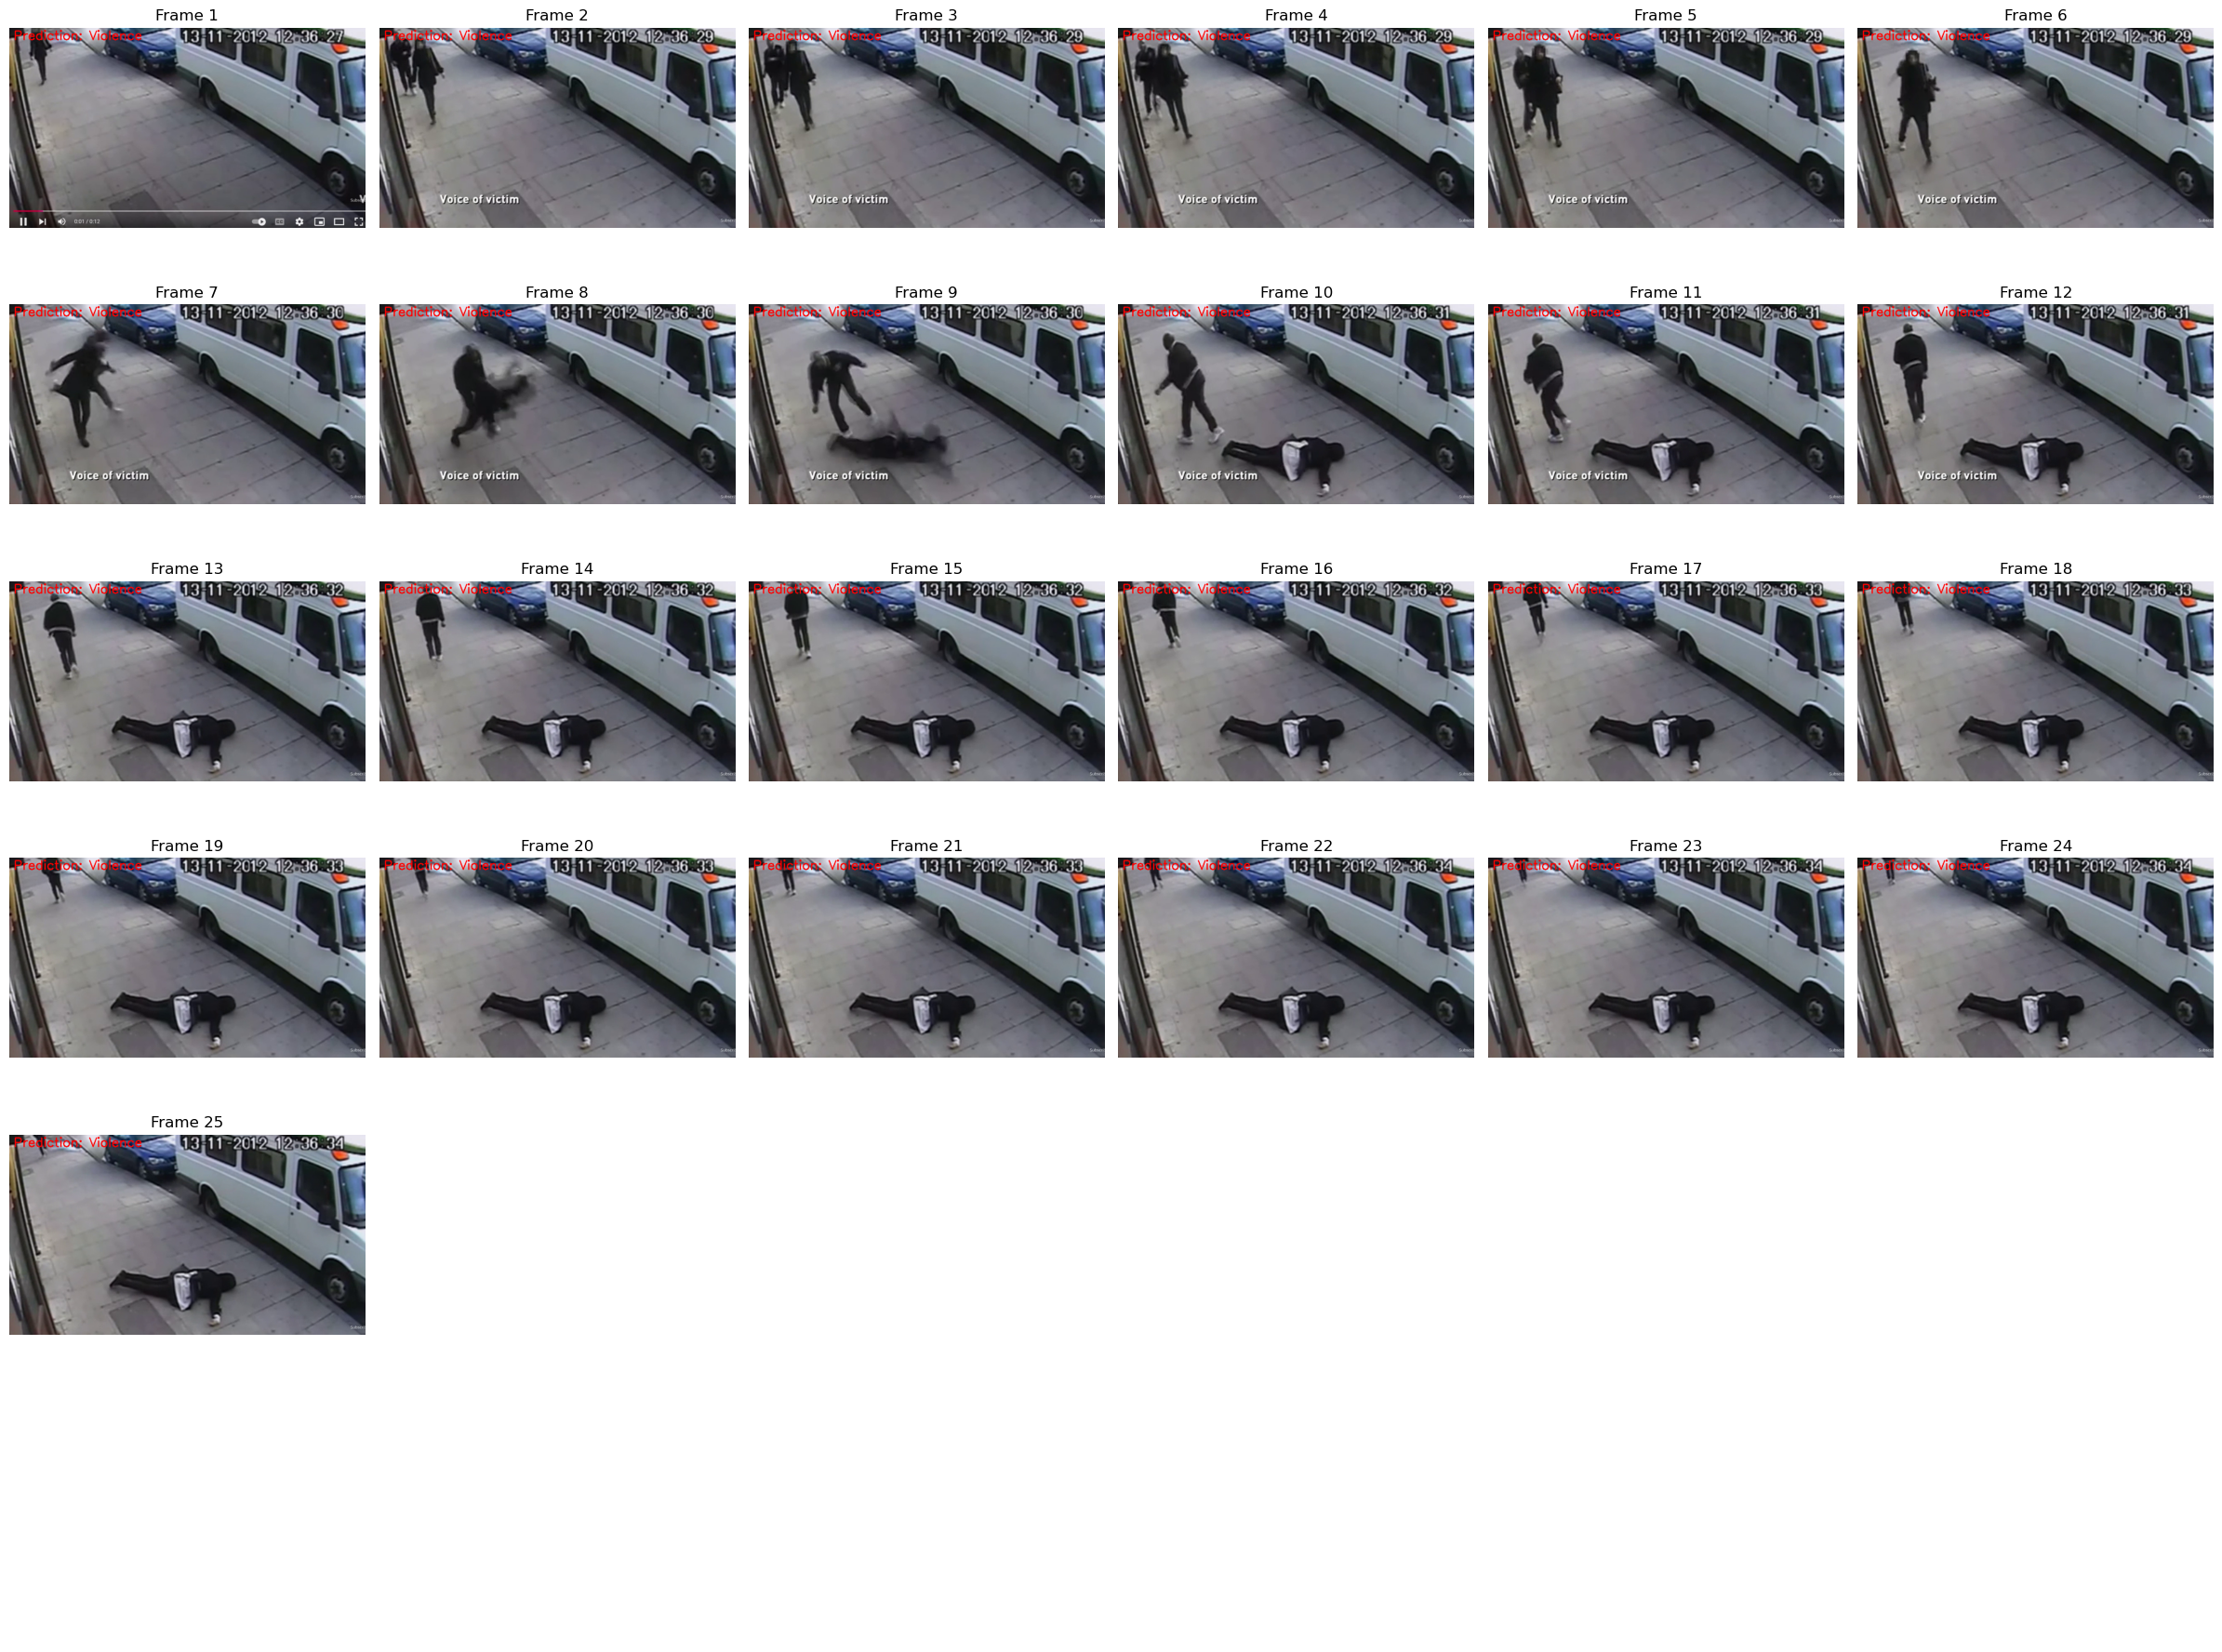

In [10]:
# Display stored violence-detected frames
if violent_frames:
    print(f"Number of violence-detected frames: {len(violent_frames)}")
    display_stored_violence_frames(violent_frames)
else:
    print("No violence-detected frames were stored.")